In [39]:
from rdkit import Chem
from rdkit.Chem import AllChem
from espsim.helpers import mlCharges
from espsim import GetEspSim
import numpy as np
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [24]:
with open("data_benchmark_1/included_names.txt", 'r') as f:
    included_names = f.read().split('\n')[:-1]

In [30]:
suppl = Chem.rdmolfiles.SDMolSupplier('data_benchmark_1/molecules.sdf',removeHs=False)
mols=[]
for mol in suppl:
    mols.append(mol)

In [31]:
print("Loading QM RESP charges")
charges_resp=[]
for name in included_names:
    charges_resp.append(np.loadtxt('data_benchmark_1/'+name+'.resp'))

print("Loading AM1BCC charges")
charges_am1bcc=[]
for name in included_names:
    charges_am1bcc.append(np.loadtxt('data_benchmark_1/'+name+'.am1bcc'))

print("Computing Gasteiger charges")
charges_gasteiger=[]
for m in mols:
    AllChem.ComputeGasteigerCharges(m)
    charges_gasteiger.append([a.GetDoubleProp('_GasteigerCharge') for a in m.GetAtoms()])

print("Computing MMFF charges")
charges_mmff=[]
for m in mols:
    mp = AllChem.MMFFGetMoleculeProperties(m)
    charges_mmff.append([mp.GetMMFFPartialCharge(i) for i in range(m.GetNumAtoms())])

print("Computing ML charges (will print three warnings for failed predictions)")
charges_ml=mlCharges(mols)

Loading QM RESP charges
Loading AM1BCC charges
Computing Gasteiger charges
Computing MMFF charges
Computing ML charges


In [34]:
def flatten(l):
    return [item for sublist in l for item in sublist]

mae=mean_absolute_error(flatten(charges_resp),flatten(charges_gasteiger))
print("MAE Gasteiger:",mae)

mae=mean_absolute_error(flatten(charges_resp),flatten(charges_mmff))
print("MAE MMFF:",mae)

mae=mean_absolute_error(flatten(charges_resp),flatten(charges_ml))
print("MAE ML:",mae)

mae=mean_absolute_error(flatten(charges_resp),flatten(charges_am1bcc))
print("MAE AM1BCC:",mae)

MAE Gasteiger: 0.15964205457001596
MAE MMFF: 0.17078546532765806
MAE ML: 0.16517081214813012
MAE AM1BCC: 0.11681240555998937


In [37]:
limit=len(mols)
charges=[(charges_ml,"ML"),(charges_mmff,"MMFF"),(charges_gasteiger,'Gasteiger'),(charges_am1bcc,'AM1-BCC')]
metric=['tanimoto','carbo']
integrate=['gauss']
results={}

for c1,c2 in charges:
    results[c2]={}
    print("")
    for m in metric:
        sims=Parallel(n_jobs=4, verbose=0)(delayed(GetEspSim)(mols[i],mols[i],prbCharge=charges_resp[i],refCharge=c1[i],metric=m) for i in range(limit))           
        print(c2,m,np.mean(sims))
        results[c2][m]=sims


ML tanimoto 0.6095317048650741
ML carbo 0.8525394365139051

MMFF tanimoto 0.6425820903706383
MMFF carbo 0.7964298314494712

Gasteiger tanimoto 0.6001496872592484
Gasteiger carbo 0.7785237182163214

AM1-BCC tanimoto 0.7793653728367
AM1-BCC carbo 0.8766209520482272


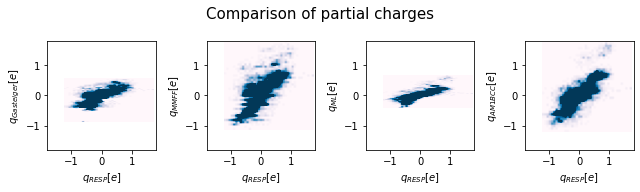

In [41]:
fig, axs = plt.subplots(1,4, figsize=(9, 2.5))

x=flatten(charges_resp)
y=flatten(charges_gasteiger)
heatmap, xedges, yedges = np.histogram2d(x, y, bins=40)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[0].imshow(heatmap.T,  extent=extent, origin='lower', cmap=plt.cm.PuBu, vmin=0, vmax=30)
axs[0].set_ylabel("$q_{Gasteiger} [e]$")

x=flatten(charges_resp)
y=flatten(charges_mmff)
heatmap, xedges, yedges = np.histogram2d(x, y, bins=40)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[1].imshow(heatmap.T,  extent=extent, origin='lower', cmap=plt.cm.PuBu, vmin=0, vmax=30)
axs[1].set_ylabel("$q_{MMFF} [e]$")

x=flatten(charges_resp)
y=flatten(charges_ml)
heatmap, xedges, yedges = np.histogram2d(x, y, bins=40)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[2].imshow(heatmap.T,  extent=extent, origin='lower', cmap=plt.cm.PuBu, vmin=0, vmax=30)
axs[2].set_ylabel("$q_{ML} [e]$")

x=flatten(charges_resp)
y=flatten(charges_am1bcc)
heatmap, xedges, yedges = np.histogram2d(x, y, bins=40)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[3].imshow(heatmap.T,  extent=extent, origin='lower', cmap=plt.cm.PuBu, vmin=0, vmax=30)
axs[3].set_ylabel("$q_{AM1BCC} [e]$")

for i in range(4):
    axs[i].set_xlabel("$q_{RESP} [e]$")
    axs[i].set_xlim([-1.8,1.8])
    axs[i].set_ylim([-1.8,1.8])

fig.suptitle("Comparison of partial charges",fontsize=15)
fig.tight_layout()

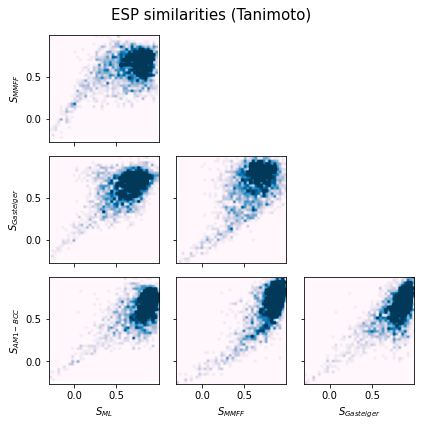

In [42]:
fig, axs = plt.subplots(3,3, figsize=(6,6),sharex=True,sharey=True)

for i,ci in enumerate(["ML","MMFF",'Gasteiger','AM1-BCC']):
    for j,cj in enumerate(["ML","MMFF",'Gasteiger','AM1-BCC']):
        if i<=j:
            continue
        x=results[ci]['tanimoto']
        y=results[cj]['tanimoto']
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=40)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        axs[i-1,j].imshow(heatmap.T,  extent=extent, origin='lower', cmap=plt.cm.PuBu, vmin=0, vmax=10)

axs[3-1,0].set_xlabel("$S_{ML}$")
axs[3-1,1].set_xlabel("$S_{MMFF}$")
axs[3-1,2].set_xlabel("$S_{Gasteiger}$")

axs[1-1,0].set_ylabel("$S_{MMFF}$")
axs[2-1,0].set_ylabel("$S_{Gasteiger}$")
axs[3-1,0].set_ylabel("$S_{AM1-BCC}$")

fig.delaxes(axs[0][1])
fig.delaxes(axs[0][2])
fig.delaxes(axs[1][2])

fig.suptitle("ESP similarities (Tanimoto)",fontsize=15)
fig.tight_layout()

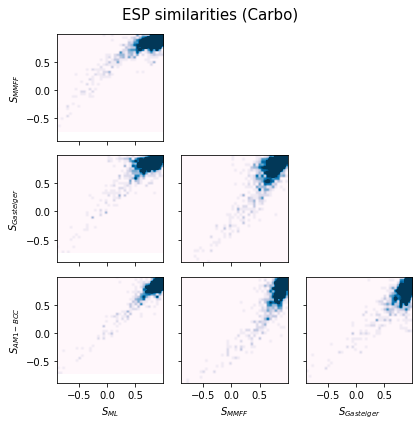

In [43]:
fig, axs = plt.subplots(3,3, figsize=(6,6),sharex=True,sharey=True)

for i,ci in enumerate(["ML","MMFF",'Gasteiger','AM1-BCC']):
    for j,cj in enumerate(["ML","MMFF",'Gasteiger','AM1-BCC']):
        if i<=j:
            continue
        x=results[ci]['carbo']
        y=results[cj]['carbo']
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=40)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        axs[i-1,j].imshow(heatmap.T,  extent=extent, origin='lower', cmap=plt.cm.PuBu, vmin=0, vmax=10)

axs[3-1,0].set_xlabel("$S_{ML}$")
axs[3-1,1].set_xlabel("$S_{MMFF}$")
axs[3-1,2].set_xlabel("$S_{Gasteiger}$")

axs[1-1,0].set_ylabel("$S_{MMFF}$")
axs[2-1,0].set_ylabel("$S_{Gasteiger}$")
axs[3-1,0].set_ylabel("$S_{AM1-BCC}$")

fig.delaxes(axs[0][1])
fig.delaxes(axs[0][2])
fig.delaxes(axs[1][2])

fig.suptitle("ESP similarities (Carbo)",fontsize=15)
fig.tight_layout()